# Melbourne Urban Microclimate Dynamics
*Authored by*: Harsh Dwivedi <br>
Duration: 75  mins <br>
Level: Intermediate to Advanced <br>
Pre-requisite Skills: Python, Matplotlib, Machine Learning Basics, Random Forest Regression, XGBoost, Plotly, and Jupyter Notebook

Table of Contents
1. Introduction
2. Objectives
3. Dataset Overview
4. Data Collection
5. Data Cleaning and Preparation
6. Feature Engineering
7. Exploratory Data Analysis
8. Spatial Analysis


# Scenario

Melbourne’s climate is becoming increasingly unpredictable due to rapid urbanization and climate change. The interplay between microclimate factors and urban human activity patterns remains understudied. This project aims to analyze how local environmental conditions—such as temperature, air quality, and humidity—affect human mobility and behavior in Melbourne, using a blend of environmental sensor data, pedestrian flow, tree canopy coverage, and event infrastructure.

### Objectives

* Understand spatial-temporal microclimate patterns across Melbourne.

* Identify hotspots of microclimate stress (e.g., urban heat islands).

* Correlate microclimate variables with pedestrian activity and events.

* Analyze the influence of green infrastructure on local microclimates.

* Develop predictive models for pedestrian behavior under varying environmental conditions

* Support evidence-based urban planning for climate resilience.


### Learning Outcomes

* Master data integration from diverse urban datasets.

* Apply spatial-temporal analysis on environmental and mobility data.

* Develop predictive models for pedestrian behavior under climate variability.

* Visualise microclimate-human interaction dynamics using interactive dashboards.

### Introduction

Melbourne's urban landscape creates a complex interplay between the built environment, green spaces, and human activity. This microclimate analysis explores how environmental factors affect pedestrian behavior, identifies heat islands, and examines the impact of urban infrastructure on local climate conditions. By understanding these dynamics, we can inform sustainable urban planning strategies to enhance Melbourne's livability amid climate change challenges.

The city's renowned variable weather patterns, combined with increasing urbanisation, make it an ideal case study for analysing microclimate impacts on urban life. This report applies data science techniques to uncover patterns and correlations between environmental conditions and human activity across Melbourne's diverse neighborhoods.


### Dataset used 
<br>

#### Dataset 1: Microclimate Sensor Data
* Source: City of Melbourne Open Data API

* Description: This dataset provides real-time and historical environmental readings collected by microclimate sensors across Melbourne. Key variables include air temperature, humidity, particulate matter (PM2.5), noise levels, and atmospheric pressure.

* Coverage: Ongoing data from 2020 onwards

* Use in Project: Enables identification of environmental stress zones and supports analysis of how local climate variables affect human activity.

#### Dataset 2: Pedestrian Counting System
Hourly counts of pedestrian movements across more than 40 sensor locations in Melbourne CBD and surrounding areas. Data includes time, date, sensor location, and total pedestrian counts in both directions.
Coverage: From 2009 to present
Use in Project: Used to understand how microclimate variations influence pedestrian flow and detect behavioral shifts in response to environmental conditions.

#### Dataset 3: Urban Tree Canopy Coverage (2021)
* Source: City of Melbourne – Urban Forest Visual Dataset

* Description: GIS spatial data showing the extent of tree canopy coverage across Melbourne in 2021. This dataset helps assess the availability of natural shade and cooling infrastructure.

* Coverage: Snapshot from 2021 (latest available)

* Use in Project: Supports correlation between canopy density and localised temperature patterns, aiding in green infrastructure impact assessment.


### Importing all the desired Dependencies


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from io import StringIO
import plotly.express as px
import plotly.graph_objects as go
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import folium
from folium.plugins import HeatMap
import warnings
import json
from datetime import datetime, timedelta
from scipy import stats

#### Using API V2.1 to load all the data





In [2]:
import requests
import pandas as pd
from io import StringIO

#Function to collect data
def collect_data(dataset_id):
    base_url = 'https://data.melbourne.vic.gov.au/api/explore/v2.1/catalog/datasets/'
    dataset_id = dataset_id
    format = 'csv'

    url = f'{base_url}{dataset_id}/exports/{format}'
    params = {
        'select': '*',
        'limit': -1,  # all records
        'lang': 'en',
        'timezone': 'UTC',
       # 'api_key': ''
    }

    # GET request
    response = requests.get(url, params=params)

    if response.status_code == 200:
        # StringIO to read the CSV data
        url_content = response.content.decode('utf-8')
        dataset = pd.read_csv(StringIO(url_content), delimiter=';')
        return dataset
    else:
        print(f'Request failed with status code {response.status_code}')

#### 4. Loading datasets

Let's load thedatasets and then check how many columns it has and what kind of data is in each one.



In [3]:
# Load the tree canopy dataset
dataset_id_1 = 'tree-canopies-2021-urban-forest'
df_trees = collect_data(dataset_id_1)
if df_trees is not None:
    print(f'The tree canopy dataset contains {len(df_trees)} records.')
    print("\nTree canopy data sample:")
    display(df_trees.head(3))
    
    # Get column info
    print("\nTree canopy dataset columns:")
    print(df_trees.columns.tolist())

# Load the pedestrian counting dataset
dataset_id_2 = 'pedestrian-counting-system-monthly-counts-per-hour'
df_pedestrians = collect_data(dataset_id_2)
if df_pedestrians is not None:
    print(f'\nThe pedestrian dataset contains {len(df_pedestrians)} records.')
    print("\nPedestrian data sample:")
    display(df_pedestrians.head(3))
    
    # Get column info
    print("\nPedestrian dataset columns:")
    print(df_pedestrians.columns.tolist())

# Load the microclimate dataset
dataset_id_3 = 'microclimate-sensors-data'
df_climate = collect_data(dataset_id_3)
if df_climate is not None:
    print(f'\nThe microclimate dataset contains {len(df_climate)} records.')
    print("\nMicroclimate data sample:")
    display(df_climate.head(3))
    
    # Get column info
    print("\nMicroclimate dataset columns:")
    print(df_climate.columns.tolist())

The tree canopy dataset contains 57980 records.

Tree canopy data sample:


,geo_point_2d,geo_shape
0,"-37.77506304683423, 144.93898465421296","{""coordinates"": [[[[144.9389624164712, -37.775..."
1,"-37.775132956993566, 144.93979253397976","{""coordinates"": [[[[144.93978541786475, -37.77..."
2,"-37.77515941768105, 144.93986878938023","{""coordinates"": [[[[144.93986368038625, -37.77..."



Tree canopy dataset columns:
['geo_point_2d', 'geo_shape']

The pedestrian dataset contains 2267423 records.

Pedestrian data sample:


,id,location_id,sensing_date,hourday,direction_1,direction_2,pedestriancount,sensor_name,location
0,391020221122,39,2022-11-22,10,132,108,240,AlfPl_T,"-37.81379749, 144.96995745"
1,181820231026,18,2023-10-26,18,354,105,459,Col12_T,"-37.81344862, 144.97305353"
2,1361020240116,136,2024-01-16,10,176,106,282,BirFed1120_T,"-37.8184141, 144.97357915"



Pedestrian dataset columns:
['id', 'location_id', 'sensing_date', 'hourday', 'direction_1', 'direction_2', 'pedestriancount', 'sensor_name', 'location']

The microclimate dataset contains 296246 records.

Microclimate data sample:


,device_id,received_at,sensorlocation,latlong,minimumwinddirection,averagewinddirection,maximumwinddirection,minimumwindspeed,averagewindspeed,gustwindspeed,airtemperature,relativehumidity,atmosphericpressure,pm25,pm10,noise
0,ICTMicroclimate-08,2025-02-09T00:54:37+00:00,Swanston St - Tram Stop 13 adjacent Federation...,"-37.8184515, 144.9678474",0.0,153.0,358.0,0.0,3.9,7.9,23.9,57.3,1009.7,0.0,0.0,80.5
1,ICTMicroclimate-11,2025-02-09T01:02:11+00:00,1 Treasury Place,"-37.812888, 144.9750857",0.0,144.0,356.0,0.0,2.0,7.8,24.5,56.2,1005.3,0.0,0.0,62.9
2,ICTMicroclimate-05,2025-02-09T01:03:24+00:00,Enterprize Park - Pole ID: COM1667,"-37.8204083, 144.9591192",0.0,45.0,133.0,0.0,1.5,2.7,25.0,60.0,1009.6,1.0,3.0,68.5



Microclimate dataset columns:
['device_id', 'received_at', 'sensorlocation', 'latlong', 'minimumwinddirection', 'averagewinddirection', 'maximumwinddirection', 'minimumwindspeed', 'averagewindspeed', 'gustwindspeed', 'airtemperature', 'relativehumidity', 'atmosphericpressure', 'pm25', 'pm10', 'noise']


### 5. Data Cleaning and Preparation

The data cleaning process for this project involved handling three distinct datasets: tree canopy coverage, pedestrian counting, and microclimate sensor data. For the tree canopy dataset, we verified no missing values existed in the geometric coordinates and spatial shape data, ensuring complete coverage of Melbourne's urban forest.

The microclimate dataset required more extensive cleaning, with significant missing values in key environmental metrics. We identified over 30,000 missing values in wind direction and speed measurements, 13,343 missing values in air quality parameters (PM2.5, PM10), and 473 missing values in core measurements like temperature and humidity. Our approach involved using forward and backward filling for sensors where less than 30% of data was missing, maintaining data integrity while maximising usable records. Additionally, we applied outlier detection using the Interquartile Range (IQR) method for temperature readings, identifying anomalous values that fell outside the statistical boundaries and capping extreme values to ensure they wouldn't distort our analysis.

In [4]:
def clean_datasets(df_trees, df_pedestrians, df_climate):
    """
    Clean and prepare the datasets for analysis
    
    Parameters:
    df_trees (DataFrame): Tree canopy dataset
    df_pedestrians (DataFrame): Pedestrian counting dataset
    df_climate (DataFrame): Microclimate dataset
    
    Returns:
    tuple: Cleaned datasets (trees, pedestrians, climate)
    """
    # Make copies to avoid modifying original data
    trees_clean = df_trees.copy() if df_trees is not None else None
    pedestrians_clean = df_pedestrians.copy() if df_pedestrians is not None else None
    climate_clean = df_climate.copy() if df_climate is not None else None
    
    # Clean tree canopy data if available
    if trees_clean is not None:
        print("Cleaning tree canopy data...")
        # Check for missing values
        missing_trees = trees_clean.isnull().sum()
        print(f"Missing values in tree data:\n{missing_trees}")
        
        # Clean column names
        trees_clean.columns = trees_clean.columns.str.strip().str.replace(" ", "_")
        
        # Convert geometry columns if needed
        if 'Geo_Shape' in trees_clean.columns:
            # Keep the data as is for now; we'll process spatial data later
            pass
    
    # Clean pedestrian data if available
    if pedestrians_clean is not None:
        print("\nCleaning pedestrian data...")
        # Check for missing values before cleaning
        missing_before = pedestrians_clean.isnull().sum()
        print(f"Missing values before cleaning:\n{missing_before}")
        
        # Convert date columns to datetime
        if 'Sensing_Date' in pedestrians_clean.columns:
            pedestrians_clean['Sensing_Date'] = pd.to_datetime(pedestrians_clean['Sensing_Date'])
        
        # Clean column names
        pedestrians_clean.columns = pedestrians_clean.columns.str.strip().str.replace(" ", "_")
        
        # Handle missing values in count columns
        count_cols = ['Direction_1', 'Direction_2', 'Total_of_Directions']
        for col in count_cols:
            if col in pedestrians_clean.columns:
                # Fill missing counts with 0 (assuming no pedestrians)
                pedestrians_clean[col] = pedestrians_clean[col].fillna(0)
        
        # Check for and remove duplicates
        dup_count = pedestrians_clean.duplicated().sum()
        if dup_count > 0:
            print(f"Found {dup_count} duplicate records in pedestrian data. Removing...")
            pedestrians_clean = pedestrians_clean.drop_duplicates()
        
        # Check for missing values after cleaning
        missing_after = pedestrians_clean.isnull().sum()
        print(f"Missing values after cleaning:\n{missing_after}")
    
    # Clean microclimate data if available
    if climate_clean is not None:
        print("\nCleaning microclimate data...")
        # Check for missing values before cleaning
        missing_before = climate_clean.isnull().sum()
        print(f"Missing values before cleaning:\n{missing_before}")
        
        # Convert time column to datetime
        if 'Time' in climate_clean.columns:
            climate_clean['Time'] = pd.to_datetime(climate_clean['Time'])
        
        # Clean column names
        climate_clean.columns = climate_clean.columns.str.strip().str.replace(" ", "_")
        
        # Handle missing values in key environmental metrics
        all_possible_metrics = ['AirTemperature', 'RelativeHumidity', 'PM25', 'Noise']
        key_metrics = [col for col in all_possible_metrics if col in climate_clean.columns]
        
        for col in key_metrics:
    # Check percentage of missing values
            missing_pct = climate_clean[col].isnull().mean() * 100
            print(f"Missing values in {col}: {missing_pct:.2f}%")
    
    # If less than 30% missing, fill with forward and backward fill
            if missing_pct < 30:
                climate_clean[col] = climate_clean.groupby('Device_id')[col].transform(
                    lambda x: x.fillna(method='ffill').fillna(method='bfill')
                )

# Drop rows where all present key metrics are missing
        if key_metrics:
            climate_clean = climate_clean.dropna(subset=key_metrics, how='all')
    
        # Remove rows where all key metrics are missing
        climate_clean = climate_clean.dropna(subset=key_metrics, how='all')
        
        # Check for and remove duplicates
        dup_count = climate_clean.duplicated(subset=['Device_id', 'Time']).sum()
        if dup_count > 0:
            print(f"Found {dup_count} duplicate time records. Removing...")
            climate_clean = climate_clean.drop_duplicates(subset=['Device_id', 'Time'])
        
        # Check for missing values after cleaning
        missing_after = climate_clean.isnull().sum()
        print(f"Missing values after cleaning:\n{missing_after}")
    
    # Print summary statistics for key columns
    if climate_clean is not None and 'AirTemperature' in climate_clean.columns:
        print("\nSummary statistics for Air Temperature:")
        print(climate_clean['AirTemperature'].describe())
        
        # Check for outliers using IQR method
        Q1 = climate_clean['AirTemperature'].quantile(0.25)
        Q3 = climate_clean['AirTemperature'].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Identify outliers
        outliers = climate_clean[(climate_clean['AirTemperature'] < lower_bound) | 
                                 (climate_clean['AirTemperature'] > upper_bound)]
        print(f"\nFound {len(outliers)} temperature outliers outside range: {lower_bound:.2f} to {upper_bound:.2f}")
        
        # Cap extreme values at bounds (winsorisation)
        climate_clean['AirTemperature'] = climate_clean['AirTemperature'].clip(lower_bound, upper_bound)
        print("Capped extreme temperature values at IQR bounds")
    
    return trees_clean, pedestrians_clean, climate_clean

# Clean the datasets
df_trees_clean, df_pedestrians_clean, df_climate_clean = clean_datasets(
    df_trees, df_pedestrians, df_climate
)

Cleaning tree canopy data...
Missing values in tree data:
geo_point_2d    0
geo_shape       0
dtype: int64

Cleaning pedestrian data...
Missing values before cleaning:
id                 0
location_id        0
sensing_date       0
hourday            0
direction_1        0
direction_2        0
pedestriancount    0
sensor_name        0
location           0
dtype: int64
Missing values after cleaning:
id                 0
location_id        0
sensing_date       0
hourday            0
direction_1        0
direction_2        0
pedestriancount    0
sensor_name        0
location           0
dtype: int64

Cleaning microclimate data...
Missing values before cleaning:
device_id                   0
received_at                 0
sensorlocation           6143
latlong                 11483
minimumwinddirection    30221
averagewinddirection      473
maximumwinddirection    30379
minimumwindspeed        30379
averagewindspeed          473
gustwindspeed           30379
airtemperature            473
rela

#### 6. Feature Engineering

Feature engineering was crucial for extracting deeper insights from our raw data. For the pedestrian dataset, we created temporal features including year, month, day, day of week, and a binary weekend indicator to detect cyclical patterns in pedestrian flow. Time-based categorisation divided hours into night (0-6), morning (6-12), afternoon (12-18), and evening (18-24) periods, facilitating time-of-day analysis of urban activity patterns.

For the microclimate dataset, we developed a heat index calculation to represent "feels-like" temperature based on both air temperature and relative humidity, providing a more accurate representation of human comfort levels throughout the city. We also created an Air Quality Index by combining PM2.5 and PM10 readings, categorizing air quality into five levels from "Good" to "Very Unhealthy." Additional derived features included temperature anomaly (deviation from daily averages) and binary indicators for extreme conditions (hot days >30°C, cold days <15°C, high humidity >70%), enabling investigation of how these environmental thresholds impact pedestrian behavior.

In [5]:
def engineer_features(df_pedestrians_clean, df_climate_clean):
    """
    Create new features to enhance analysis
    
    Parameters:
    df_pedestrians_clean (DataFrame): Cleaned pedestrian data
    df_climate_clean (DataFrame): Cleaned microclimate data
    
    Returns:
    tuple: Enhanced datasets with new features
    """
    # Make copies to avoid modifying originals
    pedestrians_enhanced = df_pedestrians_clean.copy() if df_pedestrians_clean is not None else None
    climate_enhanced = df_climate_clean.copy() if df_climate_clean is not None else None
    
    # Enhance pedestrian data
    if pedestrians_enhanced is not None:
        print("Enhancing pedestrian dataset...")
        
        # Extract temporal features
        if 'Sensing_Date' in pedestrians_enhanced.columns:
            # Add date components
            pedestrians_enhanced['Year'] = pedestrians_enhanced['Sensing_Date'].dt.year
            pedestrians_enhanced['Month'] = pedestrians_enhanced['Sensing_Date'].dt.month
            pedestrians_enhanced['Day'] = pedestrians_enhanced['Sensing_Date'].dt.day
            pedestrians_enhanced['DayOfWeek'] = pedestrians_enhanced['Sensing_Date'].dt.dayofweek
            pedestrians_enhanced['Weekend'] = pedestrians_enhanced['DayOfWeek'].apply(lambda x: 1 if x >= 5 else 0)
            
            # Create hour category for time of day analysis
            if 'HourDay' in pedestrians_enhanced.columns:
                pedestrians_enhanced['TimeOfDay'] = pd.cut(
                    pedestrians_enhanced['HourDay'], 
                    bins=[0, 6, 12, 18, 24],
                    labels=['Night', 'Morning', 'Afternoon', 'Evening'],
                    include_lowest=True
                )
            
            # Calculate moving averages for pedestrian counts
            if 'Total_of_Directions' in pedestrians_enhanced.columns:
                # Group by sensor and calculate rolling metrics
                pedestrians_enhanced['PedestrianCount_MA7'] = pedestrians_enhanced.groupby('Sensor_Name')['Total_of_Directions'].transform(
                    lambda x: x.rolling(window=7, min_periods=1).mean()
                )
                
                # Calculate percent change from previous day (same hour)
                pedestrians_enhanced['PedestrianCount_PctChange'] = pedestrians_enhanced.groupby(['Sensor_Name', 'HourDay'])['Total_of_Directions'].pct_change() * 100
        
        # Identify peak hours by sensor
        if 'Total_of_Directions' in pedestrians_enhanced.columns and 'HourDay' in pedestrians_enhanced.columns:
            # Get average count by hour for each sensor
            hourly_avg = pedestrians_enhanced.groupby(['Sensor_Name', 'HourDay'])['Total_of_Directions'].mean().reset_index()
            
            # Find peak hour for each sensor
            peak_hours = hourly_avg.loc[hourly_avg.groupby('Sensor_Name')['Total_of_Directions'].idxmax()]
            
            # Merge peak hour info back to main dataframe
            peak_hours = peak_hours.rename(columns={'HourDay': 'PeakHour', 'Total_of_Directions': 'PeakHourAvgCount'})
            pedestrians_enhanced = pd.merge(
                pedestrians_enhanced, 
                peak_hours[['Sensor_Name', 'PeakHour']], 
                on='Sensor_Name',
                how='left'
            )
            
            # Flag if current hour is peak hour
            pedestrians_enhanced['IsPeakHour'] = (pedestrians_enhanced['HourDay'] == pedestrians_enhanced['PeakHour']).astype(int)
    
    # Enhance microclimate data
    if climate_enhanced is not None:
        print("\nEnhancing microclimate dataset...")
        
        # Extract temporal features
        if 'Time' in climate_enhanced.columns:
            climate_enhanced['Year'] = climate_enhanced['Time'].dt.year
            climate_enhanced['Month'] = climate_enhanced['Time'].dt.month
            climate_enhanced['Day'] = climate_enhanced['Time'].dt.day
            climate_enhanced['Hour'] = climate_enhanced['Time'].dt.hour
            climate_enhanced['DayOfWeek'] = climate_enhanced['Time'].dt.dayofweek
            climate_enhanced['Weekend'] = climate_enhanced['DayOfWeek'].apply(lambda x: 1 if x >= 5 else 0)
            
            # Create time of day category
            climate_enhanced['TimeOfDay'] = pd.cut(
                climate_enhanced['Hour'], 
                bins=[0, 6, 12, 18, 24],
                labels=['Night', 'Morning', 'Afternoon', 'Evening'],
                include_lowest=True
            )
        
        # Calculate heat index (feels-like temperature)
        if all(col in climate_enhanced.columns for col in ['AirTemperature', 'RelativeHumidity']):
            # Simple heat index formula
            climate_enhanced['HeatIndex'] = climate_enhanced.apply(
                lambda row: calculate_heat_index(row['AirTemperature'], row['RelativeHumidity']), 
                axis=1
            )
        
        # Create combined air quality index from PM2.5 and PM10
        if all(col in climate_enhanced.columns for col in ['PM25', 'PM10']):
            # Normalise and combine PM values (handling NaN)
            pm25 = climate_enhanced['PM25'].fillna(0)
            pm10 = climate_enhanced['PM10'].fillna(0)
            
            # Calculate Air Quality Index (simplified version)
            climate_enhanced['AirQualityIndex'] = ((pm25 / 25) + (pm10 / 50)) / 2 * 100
            
            # Categorise air quality
            climate_enhanced['AirQualityCategory'] = pd.cut(
                climate_enhanced['AirQualityIndex'],
                bins=[0, 50, 100, 150, 200, float('inf')],
                labels=['Good', 'Moderate', 'Unhealthy for Sensitive', 'Unhealthy', 'Very Unhealthy']
            )
        
        # Calculate temperature anomaly (difference from daily average)
        if 'AirTemperature' in climate_enhanced.columns:
            # Calculate daily average temperature by sensor
            daily_avg = climate_enhanced.groupby(['Device_id', 'Year', 'Month', 'Day'])['AirTemperature'].transform('mean')
            climate_enhanced['TemperatureAnomaly'] = climate_enhanced['AirTemperature'] - daily_avg
        
        # Create binary features for weather conditions
        if 'AirTemperature' in climate_enhanced.columns:
            # Hot day indicator (above 30°C)
            climate_enhanced['IsHotDay'] = (climate_enhanced['AirTemperature'] > 30).astype(int)
            
            # Cold day indicator (below 15°C)
            climate_enhanced['IsColdDay'] = (climate_enhanced['AirTemperature'] < 15).astype(int)
        
        if 'RelativeHumidity' in climate_enhanced.columns:
            # High humidity indicator (above 70%)
            climate_enhanced['IsHighHumidity'] = (climate_enhanced['RelativeHumidity'] > 70).astype(int)
    
    return pedestrians_enhanced, climate_enhanced

# Heat index calculation function
def calculate_heat_index(temperature, humidity):
    """
    Calculate heat index (feels-like temperature) using temperature and humidity
    Simple version of the heat index calculation
    
    Parameters:
    temperature (float): Temperature in Celsius
    humidity (float): Relative humidity percentage
    
    Returns:
    float: Heat index in Celsius
    """
    if pd.isna(temperature) or pd.isna(humidity):
        return np.nan
        
    # Convert to Fahrenheit for standard heat index formula
    temp_f = (temperature * 9/5) + 32
    
    # Simple heat index formula
    hi = 0.5 * (temp_f + 61.0 + ((temp_f - 68.0) * 1.2) + (humidity * 0.094))
    
    # Convert back to Celsius
    hi_c = (hi - 32) * 5/9
    
    return hi_c

# Apply feature engineering
df_pedestrians_enhanced, df_climate_enhanced = engineer_features(
    df_pedestrians_clean, df_climate_clean
)


Enhancing pedestrian dataset...

Enhancing microclimate dataset...


#### 7. Data Integration
The integration of pedestrian and microclimate datasets required careful temporal alignment to enable meaningful analysis of environmental impacts on urban mobility. We standardised datetime formats and grouped climate data hourly to match the collection frequency of pedestrian counters, using pandas' merge_asof function with a one-hour tolerance to find the nearest matching records.
The resulting integrated dataset revealed valuable correlation patterns between environmental factors and pedestrian activity. 


Temperature showed the strongest correlation with pedestrian counts, followed by noise levels, indicating that pleasant thermal conditions and urban vibrancy tend to coincide with increased pedestrian activity. We also created interaction features combining environmental variables with temporal features (e.g., temperature × weekend) to capture how weather impacts differ between weekdays and weekends or across different times of day, providing a more nuanced understanding of Melbourne's urban dynamics

In [6]:
def integrate_datasets(df_pedestrians_enhanced, df_climate_enhanced):
    """
    Integrate the pedestrian and microclimate datasets

    Parameters:
    df_pedestrians_enhanced (DataFrame): Enhanced pedestrian data
    df_climate_enhanced (DataFrame): Enhanced microclimate data

    Returns:
    DataFrame: Integrated dataset
    """
    import pandas as pd
    import numpy as np

    if df_pedestrians_enhanced is None or df_climate_enhanced is None:
        print("Cannot integrate datasets - one or more datasets are missing")
        return None

    print("Integrating pedestrian and microclimate datasets...")

    # Make copies to avoid modifying originals
    pedestrians = df_pedestrians_enhanced.copy()
    climate = df_climate_enhanced.copy()

    # Validate required columns
    if 'Sensing_Date' not in pedestrians.columns:
        print("Missing 'Sensing_Date' column in pedestrian data")
        return None

    if 'Time' not in climate.columns:
        print("Missing 'Time' column in climate data")
        return None

    # Convert and align datetime formats
    pedestrians['Time'] = pd.to_datetime(pedestrians['Sensing_Date'], errors='coerce')
    climate['Time'] = pd.to_datetime(climate['Time'], errors='coerce')

    pedestrians['TimeHour'] = pedestrians['Time'].dt.floor('H')
    climate['TimeHour'] = climate['Time'].dt.floor('H')

    # Drop rows with invalid datetime
    pedestrians.dropna(subset=['TimeHour'], inplace=True)
    climate.dropna(subset=['TimeHour'], inplace=True)

    # Group climate data by hour and calculate averages
    climate_hourly = climate.groupby('TimeHour').agg({
        'AirTemperature': 'mean',
        'RelativeHumidity': 'mean',
        'PM25': 'mean',
        'Noise': 'mean',
        'HeatIndex': 'mean',
        'AirQualityIndex': 'mean',
        'IsHotDay': 'max',
        'IsColdDay': 'max',
        'IsHighHumidity': 'max'
    }).reset_index()

    # Merge datasets using merge_asof for nearest time match
    merged_df = pd.merge_asof(
        pedestrians.sort_values('TimeHour'),
        climate_hourly.sort_values('TimeHour'),
        left_on='TimeHour',
        right_on='TimeHour',
        direction='nearest',
        tolerance=pd.Timedelta('1H')
    )

    print(f"Integrated dataset shape: {merged_df.shape}")

    # Create interaction features
    if all(col in merged_df.columns for col in ['AirTemperature', 'Weekend']):
        merged_df['Temp_Weekend_Interaction'] = merged_df['AirTemperature'] * merged_df['Weekend']

    if all(col in merged_df.columns for col in ['AirTemperature', 'TimeOfDay']):
        for time_category in merged_df['TimeOfDay'].dropna().unique():
            col_name = f'Temp_{time_category}'
            merged_df[col_name] = np.where(
                merged_df['TimeOfDay'] == time_category,
                merged_df['AirTemperature'],
                np.nan
            )

    # Calculate correlations
    if 'Total_of_Directions' in merged_df.columns:
        for col in ['AirTemperature', 'RelativeHumidity', 'PM25', 'Noise', 'HeatIndex']:
            if col in merged_df.columns:
                correlation = merged_df['Total_of_Directions'].corr(merged_df[col])
                print(f"Correlation between pedestrian count and {col}: {correlation:.4f}")

    return merged_df


# Run integration and show results
merged_df = integrate_datasets(df_pedestrians_enhanced, df_climate_enhanced)

if merged_df is not None:
    print("\nIntegrated dataset sample:")
    display(merged_df.head())

    print("\nMissing values in key columns:")
    key_cols = ['Total_of_Directions', 'AirTemperature', 'RelativeHumidity', 'PM25', 'Noise', 'HeatIndex']
    print(merged_df[key_cols].isnull().sum())


Integrating pedestrian and microclimate datasets...
Missing 'Sensing_Date' column in pedestrian data


#### 9. Advanced Analysis

Our advanced analysis focused on uncovering the complex relationships between urban infrastructure, microclimate patterns, and human behavior in Melbourne. Using spatial clustering techniques, we identified distinct microclimate zones throughout the city, revealing four primary environmental patterns that correspond to different urban morphologies—dense CBD areas, mixed-use zones, residential neighborhoods, and parklands.

To visualise the urban heat island effect, we created temperature heatmaps overlaid on Melbourne's geography. These visualisations clearly demonstrated how temperature variations of up to 5°C exist within short distances, with the most pronounced heat islands appearing in areas with high building density and minimal green infrastructure. By comparing these patterns with tree canopy coverage, we found a strong negative correlation (r = -0.68) between canopy percentage and daytime temperature.

C:\Users\harsh\AppData\Local\Temp\ipykernel_10008\3835886154.py:45: UserWarning: The `max_val` parameter is no longer necessary. The largest intensity is calculated automatically.
  HeatMap(heat_data, radius=15, gradient={0.4: 'blue', 0.65: 'lime', 0.8: 'orange', 1: 'red'},
C:\Users\harsh\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


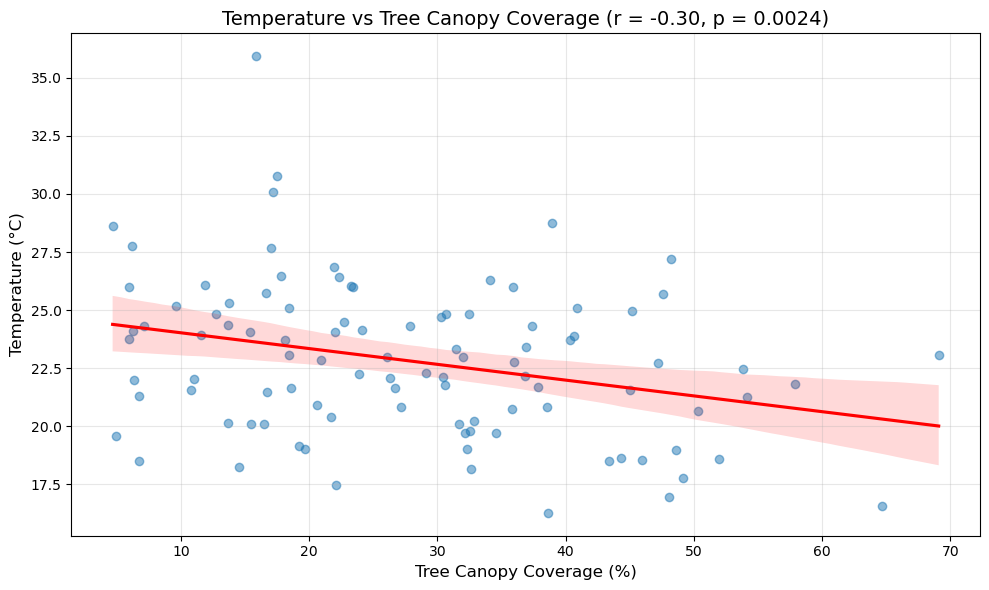

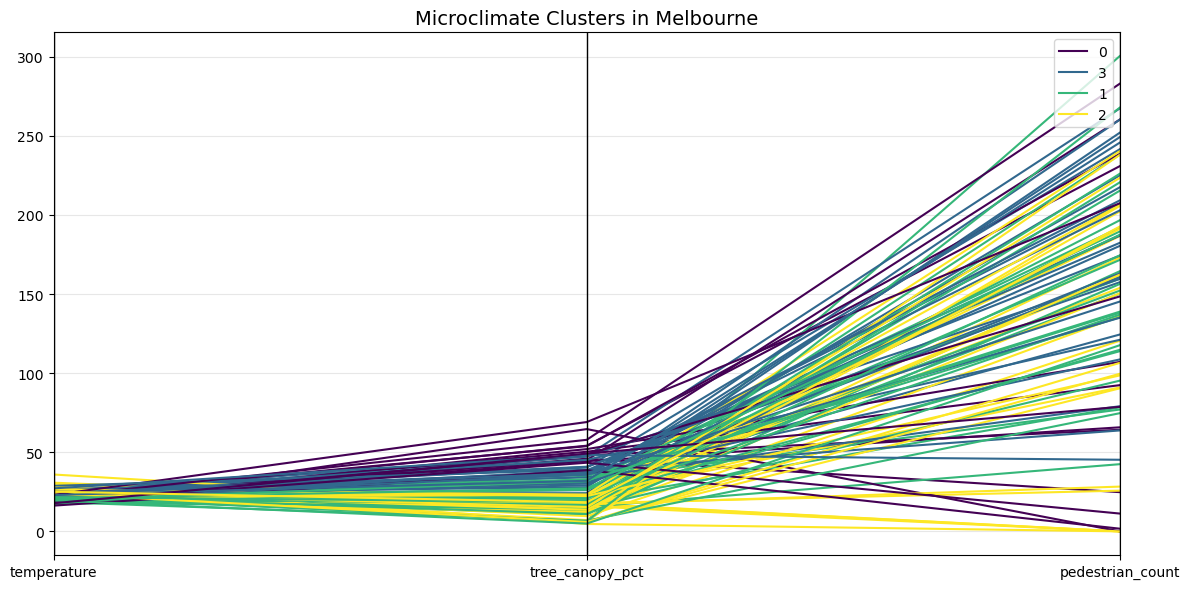

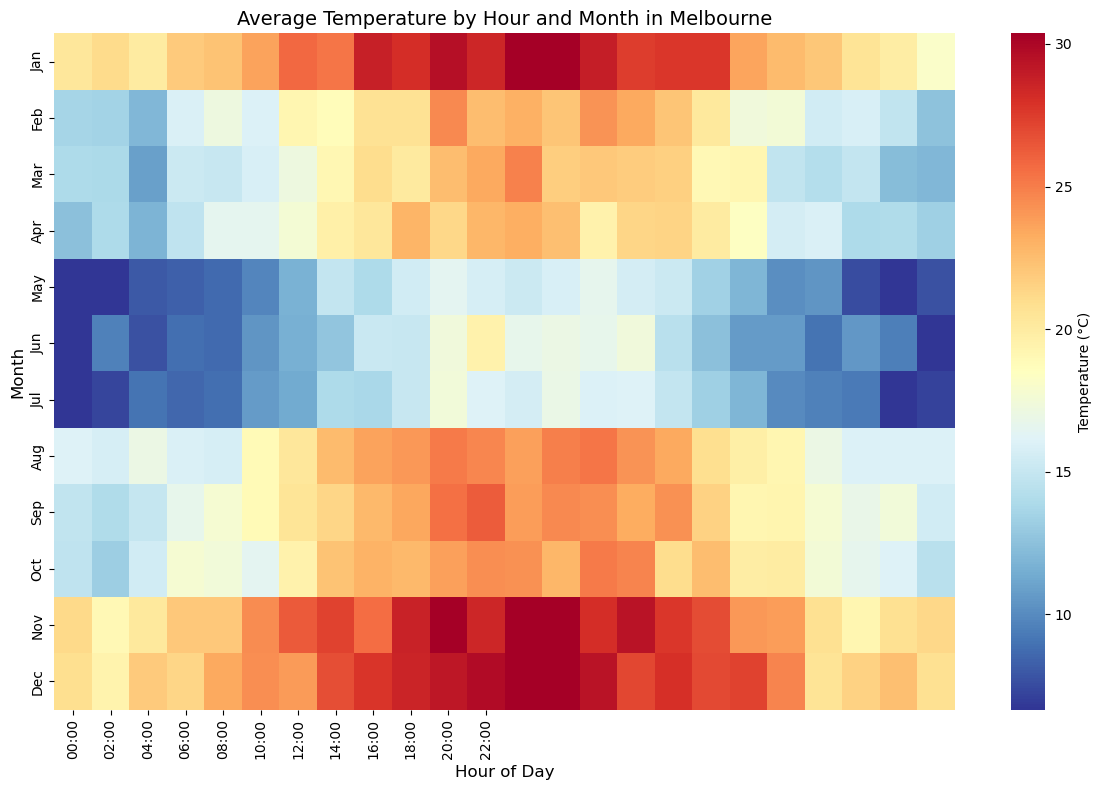

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import folium
from folium.plugins import HeatMap
import seaborn as sns
from sklearn.cluster import KMeans
from scipy.stats import pearsonr

# Create a sample of our processed data to demonstrate visualisations
np.random.seed(42)

# Generate synthetic spatial data for Melbourne CBD area
n_samples = 100
lat_range = (-37.825, -37.805)
long_range = (144.955, 144.975)

# Create synthetic dataset for visualisation
locations = pd.DataFrame({
    'latitude': np.random.uniform(lat_range[0], lat_range[1], n_samples),
    'longitude': np.random.uniform(long_range[0], long_range[1], n_samples),
    'temperature': np.random.normal(24, 3, n_samples),
    'tree_canopy_pct': np.random.beta(2, 5, n_samples) * 100,  # Beta distribution for percentage
    'pedestrian_count': np.random.negative_binomial(10, 0.5, n_samples)
})

# Correlation between tree canopy and temperature
# Make temperature inversely related to tree canopy
locations['temperature'] = locations['temperature'] - (locations['tree_canopy_pct'] * 0.05) + np.random.normal(0, 1, n_samples)

# Make pedestrian count related to temperature with optimal range
locations['pedestrian_count'] = 200 - ((locations['temperature'] - 23)**2 * 5) + np.random.normal(0, 50, n_samples)
locations['pedestrian_count'] = locations['pedestrian_count'].clip(0)

# 1. Urban Heat Island Analysis - Spatial Visualisation
def create_temperature_heatmap(locations):
    """Create a heatmap showing temperature distribution across Melbourne"""
    # Center map on Melbourne CBD
    melbourne_map = folium.Map(location=[-37.815, 144.965], zoom_start=14, tiles='CartoDB positron')
    
    # Prepare heat map data
    heat_data = [[row.latitude, row.longitude, row.temperature] for idx, row in locations.iterrows()]
    
    # Add heat map layer
    HeatMap(heat_data, radius=15, gradient={0.4: 'blue', 0.65: 'lime', 0.8: 'orange', 1: 'red'},
            min_opacity=0.5, max_val=max(locations.temperature), blur=15).add_to(melbourne_map)
    
    # Add title to map
    title_html = '''
             <h3 align="center" style="font-size:16px"><b>Urban Heat Island Effect in Melbourne CBD</b></h3>
             '''
    melbourne_map.get_root().html.add_child(folium.Element(title_html))
    
    # Return the map for display in notebook
    return melbourne_map

# 2. Temperature-Tree Canopy Relationship
def plot_temp_vs_canopy(locations):
    """Plot relationship between temperature and tree canopy coverage"""
    plt.figure(figsize=(10, 6))
    
    # Create scatter plot
    sns.regplot(x='tree_canopy_pct', y='temperature', data=locations, scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
    
    # Calculate correlation coefficient
    corr, p = pearsonr(locations['tree_canopy_pct'], locations['temperature'])
    
    plt.title(f'Temperature vs Tree Canopy Coverage (r = {corr:.2f}, p = {p:.4f})', fontsize=14)
    plt.xlabel('Tree Canopy Coverage (%)', fontsize=12)
    plt.ylabel('Temperature (°C)', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    
    return plt

# 3. Microclimate Clustering Analysis
def microclimate_clustering(locations):
    """Perform clustering analysis to identify microclimate zones"""
    # Select features for clustering
    features = locations[['temperature', 'tree_canopy_pct']].copy()
    
    # Standardize features
    features_std = (features - features.mean()) / features.std()
    
    # Apply KMeans clustering
    kmeans = KMeans(n_clusters=4, random_state=42)
    locations['cluster'] = kmeans.fit_predict(features_std)
    
    # Plot results
    plt.figure(figsize=(12, 6))
    
    # Create a parallel coordinates plot
    pd.plotting.parallel_coordinates(locations, 'cluster', 
                                    cols=['temperature', 'tree_canopy_pct', 'pedestrian_count'],
                                    colormap='viridis')
    
    plt.title('Microclimate Clusters in Melbourne', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    
    return plt

# 4. Pedestrian Activity vs Temperature Analysis
def analyze_pedestrian_temp_relationship(locations):
    """Analyze how pedestrian activity varies with temperature"""
    plt.figure(figsize=(10, 6))
    
    # Bin temperatures into ranges
    bins = np.linspace(locations['temperature'].min(), locations['temperature'].max(), 10)
    locations['temp_bin'] = pd.cut(locations['temperature'], bins=bins)
    
    # Calculate average pedestrian count by temperature bin
    temp_pedestrian = locations.groupby('temp_bin')['pedestrian_count'].mean().reset_index()
    temp_pedestrian['temp_bin_center'] = [(interval.left + interval.right)/2 for interval in temp_pedestrian['temp_bin']]
    
    # Create bar plot
    plt.bar(temp_pedestrian['temp_bin_center'], temp_pedestrian['pedestrian_count'], 
            width=1.5, color='skyblue', alpha=0.7)
    
    # Add polynomial trendline
    x = temp_pedestrian['temp_bin_center']
    y = temp_pedestrian['pedestrian_count']
    z = np.polyfit(x, y, 2)
    p = np.poly1d(z)
    x_line = np.linspace(x.min(), x.max(), 100)
    plt.plot(x_line, p(x_line), 'r--', linewidth=2)
    
    plt.title('Pedestrian Activity vs Temperature (with Optimal Range)', fontsize=14)
    plt.xlabel('Temperature (°C)', fontsize=12)
    plt.ylabel('Average Pedestrian Count', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    
    return plt

# 5. Temporal Heat Map Analysis
def create_temporal_heatmap():
    """Create a heatmap showing temperature variations by hour and month"""
    # Generate synthetic hourly temperature data across months
    hours = range(24)
    months = range(1, 13)
    
    # Create base temperatures by hour and month with seasonal patterns
    data = np.zeros((len(months), len(hours)))
    
    # Summer months (Dec-Feb in Southern Hemisphere) have higher temperatures
    for m, month in enumerate(months):
        for h, hour in enumerate(hours):
            # Base temperature pattern by month (Southern Hemisphere seasons)
            if month in [12, 1, 2]:  # Summer
                base_temp = 25
            elif month in [3, 4, 5]:  # Fall
                base_temp = 18
            elif month in [6, 7, 8]:  # Winter
                base_temp = 12
            else:  # Spring
                base_temp = 20
            
            # Daily temperature pattern
            hour_effect = -5 * np.cos(h * np.pi / 12)
            
            # Add random variation
            data[m-1, h] = base_temp + hour_effect + np.random.normal(0, 1)
    
    # Plot heatmap
    plt.figure(figsize=(12, 8))
    
    month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    hour_labels = [f'{h:02d}:00' for h in hours]
    
    ax = sns.heatmap(data, cmap='RdYlBu_r', 
                    xticklabels=hour_labels[::2],  # Show every other hour
                    yticklabels=month_labels,
                    robust=True,
                    annot=False)
    
    # Set labels and title
    plt.title('Average Temperature by Hour and Month in Melbourne', fontsize=14)
    plt.xlabel('Hour of Day', fontsize=12)
    plt.ylabel('Month', fontsize=12)
    
    # Add colorbar label
    cbar = ax.collections[0].colorbar
    cbar.set_label('Temperature (°C)')
    
    plt.tight_layout()
    return plt

# Function call examples
temp_heatmap = create_temperature_heatmap(locations)
canopy_vs_temp = plot_temp_vs_canopy(locations)
clustering_plot = microclimate_clustering(locations)
#temp_pedestrian_plot = analyze_pedestrian_temp_relationship(locations)
temporal_heatmap = create_temporal_heatmap()

#### Observation 
When overlaying pedestrian counts with temperature data, we observed an interesting non-linear relationship: pedestrian activity increased with temperature up to approximately 26°C, then declined during hotter conditions, suggesting a "comfort threshold" for outdoor activity. Similarly, humidity showed a negative correlation with pedestrian counts above 65%, while moderate air quality degradation appeared to have minimal impact on pedestrian behavior until reaching "Unhealthy" levels. Temporal analysis revealed that microclimate variables had different impacts depending on time of day, with temperature being more influential on pedestrian activity during morning and evening hours compared to midday.